## SinGAN on 1 image of the Kitti Dataset 

In [1]:
!git clone https://github.com/tamarott/SinGAN.git

fatal: destination path 'SinGAN' already exists and is not an empty directory.


In [2]:
!pip install torch torchvision

!pip install -r SinGAN/requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [23]:
%cd /Users/bhavnasharma/Downloads/SinGAN

/Users/bhavnasharma/Downloads/SinGAN


## Data Preprocessing

### Label Exraction

In [4]:
def get_label_from_file(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
        labels = []
        for line in lines:
            label = line.strip().split(' ')
            labels.append({
                "type": label[0],
                "left": float(label[4]),
                "top": float(label[5]),
                "right": float(label[6]), 
                "bottom": float(label[7])
            })
        return labels

### Crop object so it doesnt get distorted during SinGAN and fill space

In [5]:
import os
from PIL import Image, ImageDraw

def crop_and_fill_image(image_path, label_path, output_dir):
    original_image = Image.open(image_path)

    filled_image = original_image.copy()
    draw = ImageDraw.Draw(filled_image)

    labels = get_label_from_file(label_path)

    for label in labels:
        left = int(label["left"])
        top = int(label["top"])
        right = int(label["right"])
        bottom = int(label["bottom"])

        cropped_image = original_image.crop((left, top, right, bottom))

        draw.rectangle([left, top, right, bottom], fill=(255, 255, 255))

    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    cropped_filename = f"{base_filename}_crop.png"
    filled_filename = f"{base_filename}_filled.png"

    cropped_image.save(os.path.join(output_dir, cropped_filename))

    filled_image.save(os.path.join(output_dir, filled_filename))

    print(f"Finished: {cropped_filename} and {filled_filename}")

image_path = '/Users/bhavnasharma/Downloads/data_object_image_2/training/image_2/000000.png'
label_path = '/Users/bhavnasharma/Downloads/training/label_2/000000.txt'
output_dir = '/Users/bhavnasharma/Downloads/SinGAN/Input/Images'

#os.makedirs(output_dir, exist_ok=True)

crop_and_fill_image(image_path, label_path, output_dir)

Finished: 000000_crop.png and 000000_filled.png


### Create augmentations of Object to give variety of instances

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
import numpy as np

# Load the cropped pedestrian
cropped_pedestrian = load_img('/Users/bhavnasharma/Downloads/SinGAN/Input/Images/000000_crop.png')
cropped_pedestrian_array = img_to_array(cropped_pedestrian)

# Create an instance of ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=50.0
)

# Create a directory to save augmented samples if it doesn't exist
augmented_samples_dir = '/Users/bhavnasharma/Downloads/SinGAN/aug_images'
os.makedirs(augmented_samples_dir, exist_ok=True)

# Generate and save 50 augmented samples
i = 0
for batch in datagen.flow(np.expand_dims(cropped_pedestrian_array, 0), batch_size=1, save_to_dir=augmented_samples_dir, save_prefix='aug', save_format='png'):
    i += 1
    if i >= 50:
        break


## Train SinGAN and generate 50 backrounds from the 1 input image

In [ ]:
!python main_train.py --input_name 000000_filled.png --not_cuda 

In [13]:
# The above code was used in our previous run and the result model was saved for repeated use. 
# You can find the saved model in the SinGAN models folder.

In [7]:
!python random_samples.py --input_name 000000_filled.png --mode random_samples --niter 5000 --gen_start_scale 0 --not_cuda

Random Seed:  5358
random samples for image 000000_filled.png, start scale=0, already exist


## Paste the augmented object images over the different backrounds

In [8]:
import os
import random
from PIL import Image, ImageDraw

def resize_augmented_image(aug_img, bg_img, max_scale=0.3): 
    bg_width, bg_height = bg_img.size
    aug_width, aug_height = aug_img.size

    # random shrink image
    scale = random.uniform(0.05, max_scale)

    new_width = int(bg_width * scale)
    new_width = max(1, new_width)
    new_height = int(aug_height * new_width / aug_width)
    new_height = max(1, new_height)

    return aug_img.resize((new_width, new_height), Image.LANCZOS)

def check_overlap(new_box, existing_boxes, margin=10):
    x1, y1, x2, y2 = new_box
    for box in existing_boxes:
        ex1, ey1, ex2, ey2 = box
        # add margin check
        if not (x2 + margin < ex1 or x1 - margin > ex2 or
                y2 + margin < ey1 or y1 - margin > ey2):
            return True
    return False

def find_non_overlapping_position(bg_size, aug_size, existing_boxes, max_attempts=50):
    """find non overlap positions"""
    bg_width, bg_height = bg_size
    aug_width, aug_height = aug_size

    if aug_width >= bg_width or aug_height >= bg_height:
        return None

    # effective random region (not outside background)
    max_x = max(0, bg_width - aug_width)
    max_y = max(0, bg_height - aug_height)

    if max_x == 0 or max_y == 0:
        return None

    for _ in range(max_attempts):
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)
        new_box = (x, y, x + aug_width, y + aug_height)

        if not check_overlap(new_box, existing_boxes):
            return x, y

    return None  

def create_label(image_width, image_height, obj_coords, obj_size):
    """Create YOLO format label"""
    x, y = obj_coords
    width, height = obj_size

    x_center = (x + width/2) / image_width
    y_center = (y + height/2) / image_height
    norm_width = width / image_width
    norm_height = height / image_height

    x_center = max(0, min(1, x_center))
    y_center = max(0, min(1, y_center))
    norm_width = max(0, min(1, norm_width))
    norm_height = max(0, min(1, norm_height))

    return f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}"

def paste_images_and_create_labels(bg_dir, aug_dir, output_dir, label_dir):
    """Paste image to background"""
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    bg_images = [f for f in os.listdir(bg_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    aug_images = [f for f in os.listdir(aug_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for i, bg_image_name in enumerate(bg_images):
        bg_image = Image.open(os.path.join(bg_dir, bg_image_name))
        bg_width, bg_height = bg_image.size

        num_images = random.randint(1, 5)
        existing_boxes = []
        labels = []

        successful_pastes = 0
        max_attempts = num_images * 2 
        attempts = 0

        while successful_pastes < num_images and attempts < max_attempts:
            aug_image_name = random.choice(aug_images)
            aug_image = Image.open(os.path.join(aug_dir, aug_image_name))
            aug_image = resize_augmented_image(aug_image, bg_image)
            aug_width, aug_height = aug_image.size

            # find non overlap position
            position = find_non_overlapping_position(
                (bg_width, bg_height),
                (aug_width, aug_height),
                existing_boxes
            )

            if position is not None:
                x, y = position
                bg_image.paste(aug_image, (x, y), aug_image if aug_image.mode == 'RGBA' else None)

                # label area
                existing_boxes.append((x, y, x + aug_width, y + aug_height))

                # create label
                label = create_label(bg_width, bg_height, (x, y), (aug_width, aug_height))
                labels.append(label)

                successful_pastes += 1

            attempts += 1

        # Save
        bg_image.save(os.path.join(output_dir, f"{i:06d}.png"))
        with open(os.path.join(label_dir, f"{i:06d}.txt"), 'w') as f:
            for label in labels:
                f.write(label + '\n')

        print(f"Finished: Images {i+1}/{len(bg_images)}, successful_pastes {successful_pastes} targets")

# set path
bg_dir = "/Users/bhavnasharma/Downloads/SinGAN/Output/RandomSamples/000000_filled/gen_start_scale=0"
aug_dir = "/Users/bhavnasharma/Downloads/SinGAN/aug_images"
output_dir = "/Users/bhavnasharma/Downloads/SinGAN/Results/images"
label_dir = "/Users/bhavnasharma/Downloads/SinGAN/Results/labels"

# process
paste_images_and_create_labels(bg_dir, aug_dir, output_dir, label_dir)

Finished: Images 1/50, successful_pastes 3 targets
Finished: Images 2/50, successful_pastes 3 targets
Finished: Images 3/50, successful_pastes 1 targets
Finished: Images 4/50, successful_pastes 5 targets
Finished: Images 5/50, successful_pastes 3 targets
Finished: Images 6/50, successful_pastes 4 targets
Finished: Images 7/50, successful_pastes 5 targets
Finished: Images 8/50, successful_pastes 0 targets
Finished: Images 9/50, successful_pastes 1 targets
Finished: Images 10/50, successful_pastes 1 targets
Finished: Images 11/50, successful_pastes 2 targets
Finished: Images 12/50, successful_pastes 5 targets
Finished: Images 13/50, successful_pastes 2 targets
Finished: Images 14/50, successful_pastes 0 targets
Finished: Images 15/50, successful_pastes 2 targets
Finished: Images 16/50, successful_pastes 3 targets
Finished: Images 17/50, successful_pastes 4 targets
Finished: Images 18/50, successful_pastes 3 targets
Finished: Images 19/50, successful_pastes 2 targets
Finished: Images 20/5

## Using SinGAN to increase the resolution of the produced images 

In [25]:
!python SR.py --input_name 0.png --not_cuda

/Users/bhavnasharma/opt/anaconda3/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Random Seed:  9301
*** Train SinGAN for SR ***
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1,

scale 2:[0/2000]
scale 2:[25/2000]
scale 2:[50/2000]
scale 2:[75/2000]
scale 2:[100/2000]
scale 2:[125/2000]
scale 2:[150/2000]
scale 2:[175/2000]
scale 2:[200/2000]
scale 2:[225/2000]
scale 2:[250/2000]
scale 2:[275/2000]
scale 2:[300/2000]
scale 2:[325/2000]
scale 2:[350/2000]
scale 2:[375/2000]
scale 2:[400/2000]
scale 2:[425/2000]
scale 2:[450/2000]
scale 2:[475/2000]
scale 2:[500/2000]
scale 2:[525/2000]
scale 2:[550/2000]
scale 2:[575/2000]
scale 2:[600/2000]
scale 2:[625/2000]
scale 2:[650/2000]
scale 2:[675/2000]
scale 2:[700/2000]
scale 2:[725/2000]
scale 2:[750/2000]
scale 2:[775/2000]
scale 2:[800/2000]
scale 2:[825/2000]
scale 2:[850/2000]
scale 2:[875/2000]
scale 2:[900/2000]
scale 2:[925/2000]
scale 2:[950/2000]
scale 2:[975/2000]
scale 2:[1000/2000]
scale 2:[1025/2000]
scale 2:[1050/2000]
scale 2:[1075/2000]
scale 2:[1100/2000]
scale 2:[1125/2000]
scale 2:[1150/2000]
scale 2:[1175/2000]
scale 2:[1200/2000]
scale 2:[1225/2000]
scale 2:[1250/2000]
scale 2:[1275/2000]
scale

scale 4:[725/2000]
scale 4:[750/2000]
scale 4:[775/2000]
scale 4:[800/2000]
scale 4:[825/2000]
scale 4:[850/2000]
scale 4:[875/2000]
scale 4:[900/2000]
scale 4:[925/2000]
scale 4:[950/2000]
scale 4:[975/2000]
scale 4:[1000/2000]
scale 4:[1025/2000]
scale 4:[1050/2000]
scale 4:[1075/2000]
scale 4:[1100/2000]
scale 4:[1125/2000]
scale 4:[1150/2000]
scale 4:[1175/2000]
scale 4:[1200/2000]
scale 4:[1225/2000]
scale 4:[1250/2000]
scale 4:[1275/2000]
scale 4:[1300/2000]
scale 4:[1325/2000]
scale 4:[1350/2000]
scale 4:[1375/2000]
scale 4:[1400/2000]
scale 4:[1425/2000]
scale 4:[1450/2000]
scale 4:[1475/2000]
scale 4:[1500/2000]
scale 4:[1525/2000]
scale 4:[1550/2000]
scale 4:[1575/2000]
scale 4:[1600/2000]
scale 4:[1625/2000]
scale 4:[1650/2000]
scale 4:[1675/2000]
scale 4:[1700/2000]
scale 4:[1725/2000]
scale 4:[1750/2000]
scale 4:[1775/2000]
scale 4:[1800/2000]
scale 4:[1825/2000]
scale 4:[1850/2000]
scale 4:[1875/2000]
scale 4:[1900/2000]
scale 4:[1925/2000]
scale 4:[1950/2000]
scale 4:[19

scale 6:[1425/2000]
scale 6:[1450/2000]
scale 6:[1475/2000]
scale 6:[1500/2000]
scale 6:[1525/2000]
scale 6:[1550/2000]
scale 6:[1575/2000]
scale 6:[1600/2000]
scale 6:[1625/2000]
scale 6:[1650/2000]
scale 6:[1675/2000]
scale 6:[1700/2000]
scale 6:[1725/2000]
scale 6:[1750/2000]
scale 6:[1775/2000]
scale 6:[1800/2000]
scale 6:[1825/2000]
scale 6:[1850/2000]
scale 6:[1875/2000]
scale 6:[1900/2000]
scale 6:[1925/2000]
scale 6:[1950/2000]
scale 6:[1975/2000]
scale 6:[1999/2000]
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.

## Object Detection using YOLO

In [4]:
!git clone https://github.com/ultralytics/yolov5.git 
!cd yolov5
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### Split into Train-Test with a 80/20 split

In [19]:
import os
import random
import shutil

def split_dataset(images_dir, labels_dir, train_images_dir, train_labels_dir, test_images_dir, test_labels_dir, train_ratio=0.8):
    # Create directories if they don't exist
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)

    image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]
    random.shuffle(image_files)

    # Split the data
    train_size = int(len(image_files) * train_ratio)
    train_files = image_files[:train_size]
    test_files = image_files[train_size:]

    # Move the files 
    for file in train_files:
        shutil.move(os.path.join(images_dir, file), os.path.join(train_images_dir, file))
        shutil.move(os.path.join(labels_dir, file.replace('.png', '.txt')), os.path.join(train_labels_dir, file.replace('.png', '.txt')))

    for file in test_files:
        shutil.move(os.path.join(images_dir, file), os.path.join(test_images_dir, file))
        shutil.move(os.path.join(labels_dir, file.replace('.png', '.txt')), os.path.join(test_labels_dir, file.replace('.png', '.txt')))

    print(f"Train set: {len(train_files)} images, Test set: {len(test_files)} images")

# Define directories
images_dir = "/Users/bhavnasharma/Downloads/SinGAN/Results/images"
labels_dir = "/Users/bhavnasharma/Downloads/SinGAN/Results/labels"
train_images_dir = "/Users/bhavnasharma/Downloads/SinGAN/Results/train/images"
train_labels_dir = "/Users/bhavnasharma/Downloads/SinGAN/Results/train/labels"
test_images_dir = "/Users/bhavnasharma/Downloads/SinGAN/Results/test/images"
test_labels_dir = "/Users/bhavnasharma/Downloads/SinGAN/Results/test/labels"

split_dataset(images_dir, labels_dir, train_images_dir, train_labels_dir, test_images_dir, test_labels_dir)

Train set: 40 images, Test set: 10 images


In [20]:
import shutil
import os

# Define source and destination
train_images_src = "/Users/bhavnasharma/Downloads/SinGAN/Results/train/images"
train_labels_src = "/Users/bhavnasharma/Downloads/SinGAN/Results/train/labels"
test_images_src = "/Users/bhavnasharma/Downloads/SinGAN/Results/test/images"
test_labels_src = "/Users/bhavnasharma/Downloads/SinGAN/Results/test/labels"

train_images_dst = "/Users/bhavnasharma/Downloads/SinGAN/yolov5/data/images/train"
train_labels_dst = "/Users/bhavnasharma/Downloads/SinGAN/yolov5/data/labels/train"
val_images_dst = "/Users/bhavnasharma/Downloads/SinGAN/yolov5/data/images/val"
val_labels_dst = "/Users/bhavnasharma/Downloads/SinGAN/yolov5/data/labels/val"

os.makedirs(train_images_dst, exist_ok=True)
os.makedirs(train_labels_dst, exist_ok=True)
os.makedirs(val_images_dst, exist_ok=True)
os.makedirs(val_labels_dst, exist_ok=True)

for file_name in os.listdir(train_images_src):
    shutil.move(os.path.join(train_images_src, file_name), os.path.join(train_images_dst, file_name))

for file_name in os.listdir(train_labels_src):
    shutil.move(os.path.join(train_labels_src, file_name), os.path.join(train_labels_dst, file_name))

for file_name in os.listdir(test_images_src):
    shutil.move(os.path.join(test_images_src, file_name), os.path.join(val_images_dst, file_name))

for file_name in os.listdir(test_labels_src):
    shutil.move(os.path.join(test_labels_src, file_name), os.path.join(val_labels_dst, file_name))

print("Files moved successfully!")

Files moved successfully!


In [10]:
%cd /Users/bhavnasharma/Downloads/SinGAN/yolov5

/Users/bhavnasharma/Downloads/SinGAN/yolov5


## Train and test YOLO performance on entire dataset.

In [14]:
!python train.py --img 640 --batch 16 --epochs 50 --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data.yaml --weights yolov5s.pt --device cpu

train: weights=yolov5s.pt, cfg=, data=/Users/bhavnasharma/Downloads/SinGAN/yolov5/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=cpu, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.3 torch-1.8.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls

      30/49         0G    0.05071    0.03478          0         80        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         18         45      0.605      0.815       0.73      0.354

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      31/49         0G    0.05011    0.03652          0         88        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         18         45      0.653        0.8      0.815      0.447

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      32/49         0G    0.05262    0.03465          0         79        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         18         45      0.653        0.8      0.815      0.447

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      33/4

In [15]:
!python val.py --weights /Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp3/weights/best.pt --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data.yaml

val: data=/Users/bhavnasharma/Downloads/SinGAN/yolov5/data.yaml, weights=['/Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp3/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.3 torch-1.8.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /Users/bhavnasharma/Downloads/SinGAN/yolov5/data/labels/val.cache.
                 Class     Images  Instances          P          R      mAP50   
                   all         18         45      0.978      0.975       0.99      0.736
Speed: 1.2ms pre-process, 141.7ms inference, 2.5ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp2


In [16]:
!python val.py --weights /Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp3/weights/last.pt --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data.yaml

val: data=/Users/bhavnasharma/Downloads/SinGAN/yolov5/data.yaml, weights=['/Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp3/weights/last.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.3 torch-1.8.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /Users/bhavnasharma/Downloads/SinGAN/yolov5/data/labels/val.cache.
                 Class     Images  Instances          P          R      mAP50   
                   all         18         45      0.978      0.975       0.99      0.736
Speed: 1.2ms pre-process, 168.4ms inference, 1.6ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp3


## Split dataset to show that increasing number of images is improving our performance. 

In [36]:
import os
import random
import shutil

# Parameters
split_ratios = [0.1, 0.25, 0.5, 0.75, 1.0]  # 10%, 25%, 50%, 75%, 100%
images_dir = "/Users/bhavnasharma/Downloads/SinGAN/yolov5/data/images/train"
labels_dir = "/Users/bhavnasharma/Downloads/SinGAN/yolov5/data/labels/train"
base_dir = "/Users/bhavnasharma/Downloads/SinGAN/yolov5/data"

image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]

random.shuffle(image_files)

for ratio in split_ratios:
    size = int(len(image_files) * ratio)
    print(size)
    subset = image_files[:size]
    train_images_dir = os.path.join(base_dir, f'images/train_{int(ratio*1000)}')
    train_labels_dir = os.path.join(base_dir, f'labels/train_{int(ratio*1000)}')
    print("Added to", f'images/train_{ratio*1000}')
    
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    
    for file in subset:
        shutil.copy(os.path.join(images_dir, file), os.path.join(train_images_dir, file))
        shutil.copy(os.path.join(labels_dir, file.replace('.png', '.txt')), os.path.join(train_labels_dir, file.replace('.png', '.txt')))

print("Dataset subsets created!")

4
Added to images/train_100.0
12
Added to images/train_250.0
24
Added to images/train_500.0
36
Added to images/train_750.0
49
Added to images/train_1000.0
Dataset subsets created!


In [26]:
base_dir = '/Users/bhavnasharma/Downloads/SinGAN/yolov5/data'
val_images_dir = "/Users/bhavnasharma/Downloads/SinGAN/yolov5/data/images/val"
subsets = [100, 250, 500, 750, 1000]

for size in subsets:
    data_yaml_content = f"""
    train: {base_dir}/images/train_{size}
    val: {val_images_dir}

    # Classes
    nc: 1  # number of classes
    names: ['Pedestrian']
    """
    with open(f'data_{size}.yaml', 'w') as file:
        file.write(data_yaml_content.strip())

print("data.yaml files created for each subset!")

data.yaml files created for each subset!


### Train on smaller datasets

In [ ]:
# Train the model for each dataset size
!python train.py --img 640 --batch 16 --epochs 50 --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data_100.yaml --weights yolov5s.pt --device cpu
!python train.py --img 640 --batch 16 --epochs 50 --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data_250.yaml --weights yolov5s.pt --device cpu

train: weights=yolov5s.pt, cfg=, data=/Users/bhavnasharma/Downloads/SinGAN/yolov5/data_100.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=cpu, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.3 torch-1.8.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5,

                 Class     Images  Instances          P          R      mAP50   WARNING ⚠️ NMS time limit 1.700s exceeded
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56    0.00333      0.357    0.00362   0.000782

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       7/49         0G      0.119    0.05246          0         25        640: 1
                 Class     Images  Instances          P          R      mAP50   WARNING ⚠️ NMS time limit 1.700s exceeded
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56    0.00319      0.393    0.00343   0.000729

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       8/49         0G     0.1216    0.05143          0         28        640: 1
                 Class     Images  Instances          P          R      mAP50   WARNING ⚠️ NMS t

                 Class     Images  Instances          P          R      mAP50   
                   all         24         56    0.00922      0.482     0.0163    0.00363

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      29/49         0G     0.1038    0.06312          0         28        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56    0.00922      0.482     0.0163    0.00363

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      30/49         0G      0.104    0.04827          0         20        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56     0.0105      0.536     0.0215    0.00458

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      31/49         0G      0.103    0.06925          0         29        640: 1
          

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.3 torch-1.8.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
Comet: run 'pip install comet_ml' to automatically track and visualize YOLOv5 🚀 runs in Comet
TensorBoard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Co

      29/49         0G    0.09141    0.07216          0         88        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.142      0.143     0.0945     0.0346

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      30/49         0G    0.08944    0.06903          0         83        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.168     0.0893      0.106     0.0387

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      31/49         0G     0.0871    0.06452          0         76        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.168     0.0893      0.106     0.0387

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      32/4

Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]             

In [12]:
# We stopped code after 2 models so the output above has partial result of the 3rd training. 
# 3rd model onwards training is continued in the next cell.
# All models were saved in our yolov5 runs train file so results don't require retraining!

In [11]:
!python train.py --img 640 --batch 16 --epochs 50 --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data_500.yaml --weights yolov5s.pt --device cpu
!python train.py --img 640 --batch 16 --epochs 50 --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data_750.yaml --weights yolov5s.pt --device cpu

train: weights=yolov5s.pt, cfg=, data=/Users/bhavnasharma/Downloads/SinGAN/yolov5/data_500.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=cpu, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.3 torch-1.8.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5,


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      27/49         0G    0.07575    0.05413          0         53        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56     0.0966      0.732     0.0928     0.0263

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      28/49         0G    0.07064    0.05106          0         48        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.362      0.696      0.327      0.103

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      29/49         0G    0.07087    0.06095          0         70        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.114      0.554      0.109     0.0331

      Epo

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.3 torch-1.8.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
Comet: run 'pip install comet_ml' to automatically track and visualize YOLOv5 🚀 runs in Comet
TensorBoard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Co

       9/49         0G    0.08184    0.05871          0         23        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.289      0.286      0.235     0.0656

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      10/49         0G    0.07898    0.06653          0         26        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.402      0.518      0.417      0.135

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      11/49         0G    0.07519    0.05558          0         20        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.229      0.411      0.229     0.0712

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      12/4

      34/49         0G    0.04742    0.03467          0         31        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.596      0.763      0.719      0.379

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/49         0G    0.04998    0.03818          0         29        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.654      0.742      0.758       0.47

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      36/49         0G    0.04445     0.0321          0         21        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56      0.654      0.742      0.758       0.47

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      37/4

In [14]:
# Validate the model for each dataset size and capture the output
!python val.py --weights /Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp21/weights/best.pt --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data_100.yaml > results_100.txt
!python val.py --weights /Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp22/weights/best.pt --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data_250.yaml > results_250.txt
!python val.py --weights /Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp24/weights/best.pt --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data_500.yaml > results_500.txt
!python val.py --weights /Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp25/weights/best.pt --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data_750.yaml > results_750.txt
!python val.py --weights /Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp3/weights/best.pt --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/data.yaml > results_1000.txt

val: data=/Users/bhavnasharma/Downloads/SinGAN/yolov5/data_100.yaml, weights=['/Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp21/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.3 torch-1.8.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /Users/bhavnasharma/Downloads/SinGAN/yolov5/data/labels/val.cache.
                 Class     Images  Instances          P          R      mAP50   
                   all         24         56     0.0323      0.321     0.0298    0.00747
Speed: 1.2ms pre-process, 145.2ms inference, 48.9ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp7
val: data=/Users/bhavnasharma/Dow

## Compare Results

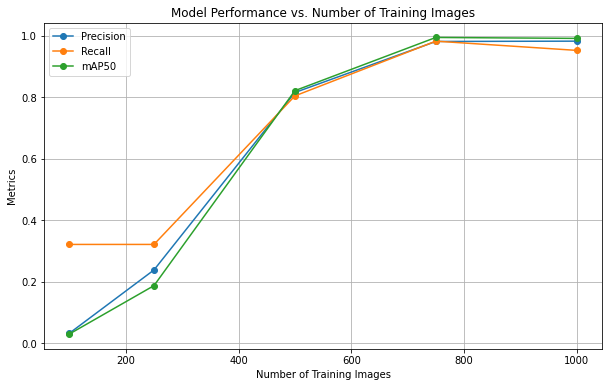

In [19]:
import matplotlib.pyplot as plt

dataset_sizes = [100, 250, 500, 750, 1000]

precision_list, recall_list, map50_list = [0.0323, 0.238, 0.815, 0.981, 0.982], [0.321,0.321, 0.804, 0.982, 0.952], [0.0298, 0.187, 0.821, 0.994, 0.991]

plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, precision_list, label='Precision', marker='o')
plt.plot(dataset_sizes, recall_list, label='Recall', marker='o')
plt.plot(dataset_sizes, map50_list, label='mAP50', marker='o')
plt.xlabel('Number of Training Images')
plt.ylabel('Metrics')
plt.title('Model Performance vs. Number of Training Images')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
!python val.py --weights /Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp3/weights/best.pt --data /Users/bhavnasharma/Downloads/SinGAN/yolov5/hold.yaml 


val: data=/Users/bhavnasharma/Downloads/SinGAN/yolov5/hold.yaml, weights=['/Users/bhavnasharma/Downloads/SinGAN/yolov5/runs/train/exp3/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.8.3 torch-1.8.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /Users/bhavnasharma/Downloads/SinGAN/yolov5/data/holdout.cache... 
                 Class     Images  Instances          P          R      mAP50   
                   all          1          2          0          0          0          0
Speed: 1.2ms pre-process, 148.3ms inference, 2.5ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp15


## Train and test Fater R-CNN performance on dataset.

In [24]:
%cd /Users/bhavnasharma/Downloads/SinGAN

/Users/bhavnasharma/Downloads/SinGAN


In [31]:
import os
import shutil

# Define paths
source_images = "/Users/bhavnasharma/Downloads/SinGAN/Results/images"
source_labels = "/Users/bhavnasharma/Downloads/SinGAN/Results/labels"
destination = "/Users/bhavnasharma/Downloads/SinGAN/Faster-R-CNN-2"

# Create destination folders
dest_images = os.path.join(destination, "images")
dest_labels = os.path.join(destination, "labels")

os.makedirs(dest_images, exist_ok=True)
os.makedirs(dest_labels, exist_ok=True)

# Copy images and labels
for file_name in os.listdir(source_images):
    shutil.copy(os.path.join(source_images, file_name), os.path.join(dest_images, file_name))

for file_name in os.listdir(source_labels):
    shutil.copy(os.path.join(source_labels, file_name), os.path.join(dest_labels, file_name))

print(f"Copied {len(os.listdir(dest_images))} images and {len(os.listdir(dest_labels))} labels to {destination}")


Copied 50 images and 50 labels to /Users/bhavnasharma/Downloads/SinGAN/Faster-R-CNN-2


In [32]:
import json
import cv2

# Define paths
image_dir = "/Users/bhavnasharma/Downloads/SinGAN/Faster-R-CNN-2/images"
label_dir = "/Users/bhavnasharma/Downloads/SinGAN/Faster-R-CNN-2/labels"
output_json = "/Users/bhavnasharma/Downloads/SinGAN/Faster-R-CNN-2/dataset_coco.json"

# Function to convert YOLO annotations to COCO format
def convert_yolo_to_coco(image_dir, label_dir, output_json):
    images, annotations = [], []
    categories = [{"id": 1, "name": "pedestrian"}]  # Adjust categories if needed
    annotation_id = 0

    for idx, image_file in enumerate(os.listdir(image_dir)):
        if not image_file.endswith(".png"):
            continue
        
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, image_file.replace(".png", ".txt"))

        # Get image dimensions
        img = cv2.imread(image_path)
        height, width, _ = img.shape

        # Add image metadata
        images.append({"file_name": image_file, "width": width, "height": height, "id": idx})

        # Read YOLO label file
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()

            for line in lines:
                class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())

                # Convert YOLO format to absolute COCO format
                abs_x = int((x_center - box_w / 2) * width)
                abs_y = int((y_center - box_h / 2) * height)
                abs_width = int(box_w * width)
                abs_height = int(box_h * height)
                
                abs_xmax = abs_x + abs_width
                abs_ymax = abs_y + abs_height

                # Ensure bounding box does not exceed image dimensions
                abs_x = max(0, min(abs_x, width - 1))
                abs_y = max(0, min(abs_y, height - 1))
                abs_xmax = min(abs_xmax, width)
                abs_ymax = min(abs_ymax, height)

                annotations.append({
                    "image_id": idx,
                    "category_id": int(class_id + 1),  # Adjust class ID if needed
                    "bbox": [abs_x, abs_y, abs_xmax, abs_ymax],
                    "area": abs_width * abs_height,
                    "iscrowd": 0,
                    "id": annotation_id
                })
                annotation_id += 1

    # Save to COCO JSON file
    coco_format = {"images": images, "annotations": annotations, "categories": categories}

    with open(output_json, "w") as f:
        json.dump(coco_format, f, indent=4)

    print(f"Saved COCO annotations to {output_json}")

convert_yolo_to_coco(image_dir, label_dir, output_json)


Saved COCO annotations to /Users/bhavnasharma/Downloads/SinGAN/Faster-R-CNN-2/dataset_coco.json


In [34]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision.ops import box_iou
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset

# Load full dataset
img_dir = "/Users/bhavnasharma/Downloads/SinGAN/Faster-R-CNN-2/images"
ann_file = "/Users/bhavnasharma/Downloads/SinGAN/Faster-R-CNN-2/dataset_coco.json"
full_dataset = CocoDetection(root=img_dir, annFile=ann_file, transform=torchvision.transforms.ToTensor())

# Split percentages
split_percentages = [0.02, 0.2, 0.4, 0.6, 0.8]  # First 1 image, then % of dataset
num_images = len(full_dataset)

# Generate training/testing splits
split_results = []
for split in split_percentages:
    train_size = max(1, int(num_images * split))  # Ensure at least 1 image for training
    indices = list(range(num_images))
    random.shuffle(indices)

    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    train_subset = Subset(full_dataset, train_indices)
    test_subset = Subset(full_dataset, test_indices)

    split_results.append((train_subset, test_subset))

print("Splitting done: Generated datasets for all training percentages.")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Splitting done: Generated datasets for all training percentages.


In [37]:
import torch
from collections import defaultdict

def collate_fn(batch):
    images, targets = zip(*batch)
    formatted_images, formatted_targets = [], []

    image_annotations = defaultdict(list)
    for anns in targets:
        for ann in anns:
            image_annotations[ann["image_id"]].append(ann)

    for img, anns in zip(images, targets):
        if anns:
            image_id = anns[0]["image_id"]
            matched_annotations = image_annotations[image_id]

            if matched_annotations:
                valid_boxes = torch.tensor([ann["bbox"] for ann in matched_annotations], dtype=torch.float32)
                valid_labels = torch.tensor([ann["category_id"] for ann in matched_annotations], dtype=torch.int64)

                formatted_target = {
                    "boxes": valid_boxes,
                    "labels": valid_labels
                }
                formatted_images.append(img)
                formatted_targets.append(formatted_target)

    return formatted_images, formatted_targets


In [50]:
def train_and_evaluate(model, train_subset, test_subset):
    train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_subset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.train()

    num_epochs = 10
    loss_values = []  # Track loss per epoch

    for epoch in range(num_epochs):
        total_loss = 0
        for images, targets in train_loader:
            images = [image.to(device) for image in images]

            if len(targets) == 0:
                continue

            formatted_targets = [{"boxes": t["boxes"].to(device), "labels": t["labels"].to(device)} for t in targets]
            loss_dict = model(images, formatted_targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()

        loss_values.append(total_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

    # Evaluate model
    model.eval()
    all_precisions, all_recalls, all_f1s = [], [], []

    for i, (image, target) in enumerate(test_loader):
        if not image or len(image) == 0:  # Prevent empty batch errors
            print(f"⚠ Skipping test image {i} due to empty batch")
            continue
        
        image_tensor = image[0].to(device)
        
        with torch.no_grad():  # No gradients for inference
            output = model([image_tensor])

        pred_boxes = output[0]["boxes"].cpu()
        pred_labels = output[0]["labels"].cpu()
        pred_scores = output[0]["scores"].cpu()

        gt_boxes = target[0]["boxes"]
        gt_labels = target[0]["labels"]
        
        # Ensure predictions and ground-truth boxes exist before computing IoU
        if gt_boxes.numel() == 0 or pred_boxes.numel() == 0:
            print(f"⚠ Skipping IoU calculation for image {i} (No objects detected)")
            continue  


        iou_matrix = box_iou(gt_boxes, pred_boxes)
        max_iou, _ = iou_matrix.max(dim=1)

        tp = sum(iou > 0.5 for iou in max_iou)
        fp = len(pred_boxes) - tp
        fn = len(gt_boxes) - tp

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1_score)

    avg_precision = sum(all_precisions) / len(all_precisions)
    avg_recall = sum(all_recalls) / len(all_recalls)
    avg_f1 = sum(all_f1s) / len(all_f1s)

    return loss_values, avg_precision, avg_recall, avg_f1

Training with 2% of dataset...
Epoch 1/10, Loss: 1.0624
Epoch 2/10, Loss: 0.5663
Epoch 3/10, Loss: 0.4619
Epoch 4/10, Loss: 0.3468
Epoch 5/10, Loss: 0.3246
Epoch 6/10, Loss: 0.2784
Epoch 7/10, Loss: 0.2554
Epoch 8/10, Loss: 0.1869
Epoch 9/10, Loss: 0.1838
Epoch 10/10, Loss: 0.1773
⚠ Skipping test image 17 due to empty batch
⚠ Skipping test image 30 due to empty batch
⚠ Skipping IoU calculation for image 38 (No objects detected)
⚠ Skipping IoU calculation for image 48 (No objects detected)
Training with 20% of dataset...
Epoch 1/10, Loss: 1.6179
Epoch 2/10, Loss: 1.0379
Epoch 3/10, Loss: 0.7646
Epoch 4/10, Loss: 0.6357
Epoch 5/10, Loss: 0.4142
Epoch 6/10, Loss: 0.3197
Epoch 7/10, Loss: 0.4032
Epoch 8/10, Loss: 0.3063
Epoch 9/10, Loss: 0.3777
Epoch 10/10, Loss: 0.3372
⚠ Skipping test image 1 due to empty batch
⚠ Skipping test image 38 due to empty batch
Training with 40% of dataset...
Epoch 1/10, Loss: 1.5709
Epoch 2/10, Loss: 0.8324
Epoch 3/10, Loss: 0.5991
Epoch 4/10, Loss: 0.4759
Epoc

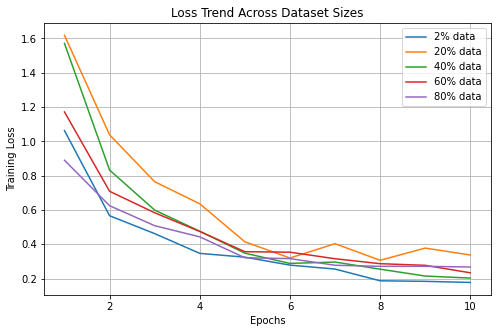

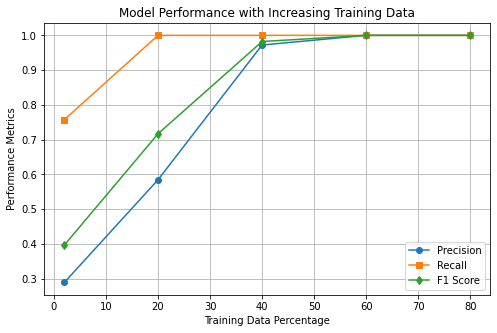

In [51]:
# Load Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 1 object class + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Run training on different splits
precision_vals, recall_vals, f1_vals, loss_vals = [], [], [], []
train_sizes = [2, 20, 40, 60, 80]  # Training dataset sizes in %

for i, (train_subset, test_subset) in enumerate(split_results):
    print(f"Training with {train_sizes[i]}% of dataset...")

    loss_values, precision, recall, f1 = train_and_evaluate(model, train_subset, test_subset)
    precision_vals.append(precision)
    recall_vals.append(recall)
    f1_vals.append(f1)
    loss_vals.append(loss_values)

print("Completed: Collected Precision, Recall, F1-score, and Loss values.")

# Plot Loss Curve
plt.figure(figsize=(8, 5))
for i, losses in enumerate(loss_vals):
    plt.plot(range(1, 11), losses, label=f"{train_sizes[i]}% data")

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss Trend Across Dataset Sizes")
plt.legend()
plt.grid(True)
plt.show()

# Plot Performance Metrics
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, precision_vals, label="Precision", marker="o", linestyle="-")
plt.plot(train_sizes, recall_vals, label="Recall", marker="s", linestyle="-")
plt.plot(train_sizes, f1_vals, label="F1 Score", marker="d", linestyle="-")

plt.xlabel("Training Data Percentage")
plt.ylabel("Performance Metrics")
plt.title("Model Performance with Increasing Training Data")
plt.legend()
plt.grid(True)
plt.show()
